In [46]:
%reload_ext autoreload
%autoreload 2  

# Load data

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"
file_name_big = "IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv"
file_name_big_big = "IrishNationalTideGaugeNetwork_8335_68d5_7ab9.csv"

file_name = file_name_big_big


df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()[700:1200]

mean_every_12_rows

700     1.933333
701     2.335083
702     2.686333
703     2.960500
704     3.058000
          ...   
1195    1.065583
1196    1.768750
1197    2.486667
1198    3.069750
1199    3.416750
Name: Water_Level_LAT, Length: 500, dtype: float64

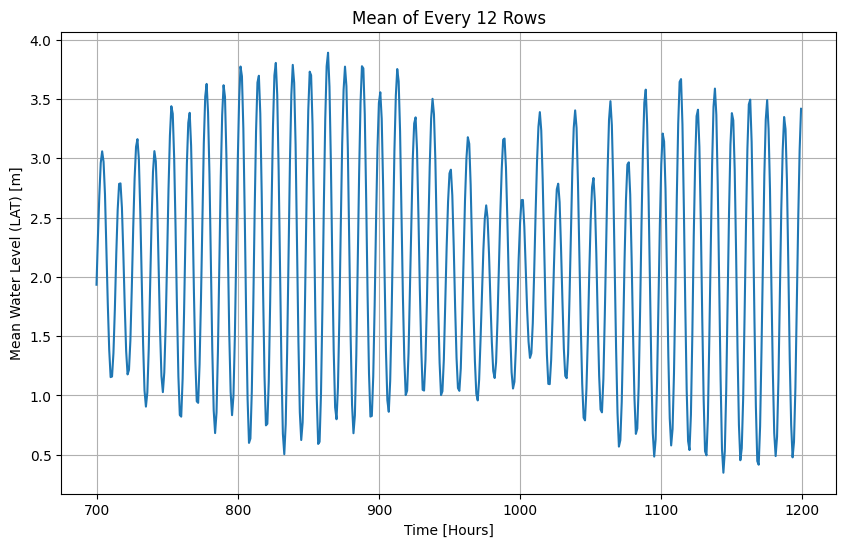

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Expectation matrix

### Format data

In [56]:
import numpy as np
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
# data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# # get test data
# test_x = data[-30:]
# print(test_x.shape)

(500,)
1.9333333333333333
(470,)


In [57]:
m = 9

n = (m-1)*5

train_matrix = np.tile(data, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# # prediction matrix
# test_matrix = np.tile(test_x, (n, 1)).transpose()
# print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (500, 40)


array([[1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333,
        1.93333333, 1.93333333, 1.93333333, 1.93333333, 1.93333333],
       [2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.33508333, 2.33508333,
        2.33508333, 2.33508333, 2.33508333, 2.3

### Generate circuit object

In [58]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_matrix.shape[0]
memory_length = 7

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 500/500 [00:01<00:00, 284.79it/s]


In [60]:
import pickle

input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
# input_state = pcvl.BasicState([0, 1, 0, 1, 0, 1, 0, 1])
# train_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
#                                                                         input_state, memory_length=memory_length)
full_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
                                                                        input_state,
                                                                        memory_length=100)

print("expectations_matrix.shape = ", np.array(full_expectation_matrix).shape)

pickle.dump(full_expectation_matrix, open(f"full_expectation_matrix_{len(full_expectation_matrix)}_no_rescale_fit_regul.pkl", "wb"))
full_expectation_matrix = full_expectation_matrix[:400]
new_data = data[:400]

Processing time steps: 100%|██████████| 500/500 [01:15<00:00,  6.66it/s]

expectations_matrix.shape =  (500, 9)


In [90]:
import pickle
# Open the full_expectation_matrix
full_expectation_matrix = pickle.load(open(f"full_expectation_matrix_2000.pkl", "rb")) # old data
# full_expectation_matrix = pickle.load(open(f"full_expectation_matrix_500_no_rescale_fit_regul.pkl", "rb")) # new data
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)

full_expectation_matrix = full_expectation_matrix[:400]
new_data = data[:400]

In [91]:
# Train Test split
split_int = 50 # 50

test_expectation_matrix = full_expectation_matrix[-split_int:]
train_expectation_matrix = full_expectation_matrix[:-split_int]
print("train_expectation_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectation_matrix.shape = ", np.array(test_expectation_matrix).shape)


test_x = new_data[-split_int:]
train_x = new_data[:-split_int]

train_expectation_matrix.shape =  (350, 9)
test_expectation_matrix.shape =  (50, 9)


# Quadratic Regression

In [92]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming 'train_expectation_matrix' and 'train_x' are defined and available

# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:-1]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# Make prediction vector
labels = np.array(train_x)[1:]
data_red = np.array(train_x)[:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)

# Transform the data to include quadratic terms
poly = PolynomialFeatures(degree=12)
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the quadratic model with Ridge regularization
# You can adjust the alpha parameter to control the strength of the regularization
reg_ridge = Ridge(alpha=2).fit(expectations_matrix_quad, labels)

# 'reg_ridge' is now a Ridge regression model fit to the quadratic terms


expectations_matrix.shape =  (349, 9)
labels: [2.33508333 2.68633333 2.9605    ]
data_red:  [1.93333333 2.33508333 2.68633333 2.9605    ]
labels shape:  (349,)


#### Predict test data

predicted_data.shape =  (50,)


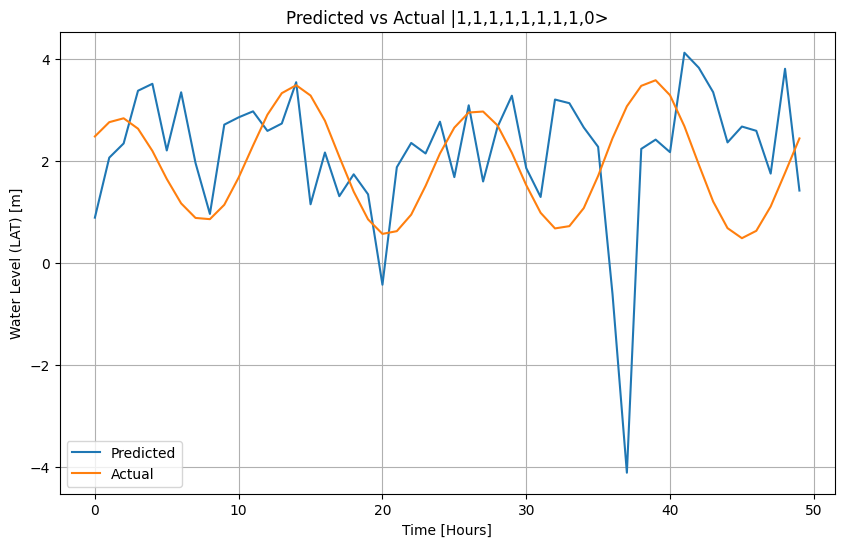

In [93]:
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)

# Make predictions using the quadratic model
predicted_test_data_quad = reg_ridge.predict(test_expectation_matrix_quad)
print("predicted_data.shape = ", predicted_test_data_quad.shape)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_test_data_quad, label=f'Predicted')
plt.plot(test_x, label='Actual')
plt.title(f'Predicted vs Actual {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)

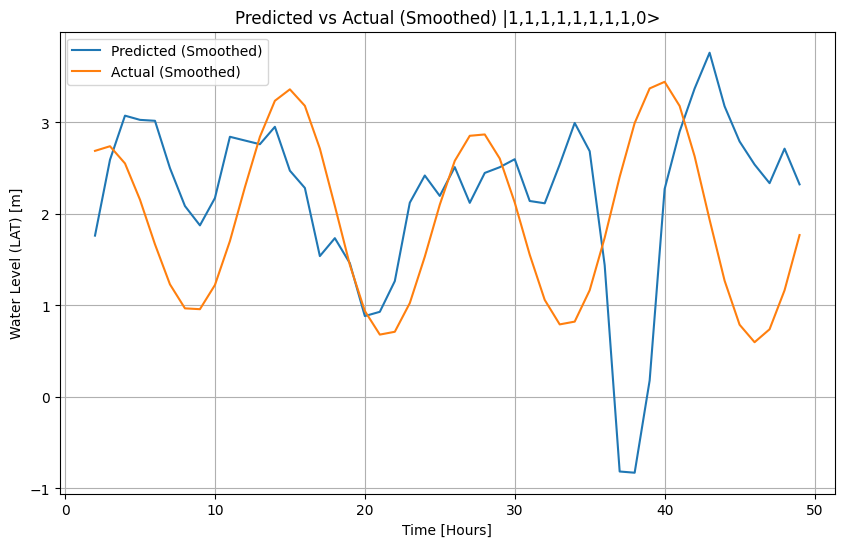

In [94]:
# Convert arrays to pandas Series for easy manipulation
predicted_series = pd.Series(predicted_test_data_quad)
actual_series = pd.Series(test_x)

# Apply a moving average (rolling mean). You can adjust the window size as needed.
window_size = 3  # This is the number of data points used for calculating the average
predicted_smoothed = predicted_series.rolling(window=window_size).mean()
actual_smoothed = actual_series.rolling(window=window_size).mean()

# Plotting the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(predicted_smoothed, label='Predicted (Smoothed)')
plt.plot(actual_smoothed, label='Actual (Smoothed)')
plt.title(f'Predicted vs Actual (Smoothed) {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)
plt.show()

#### Predict train data

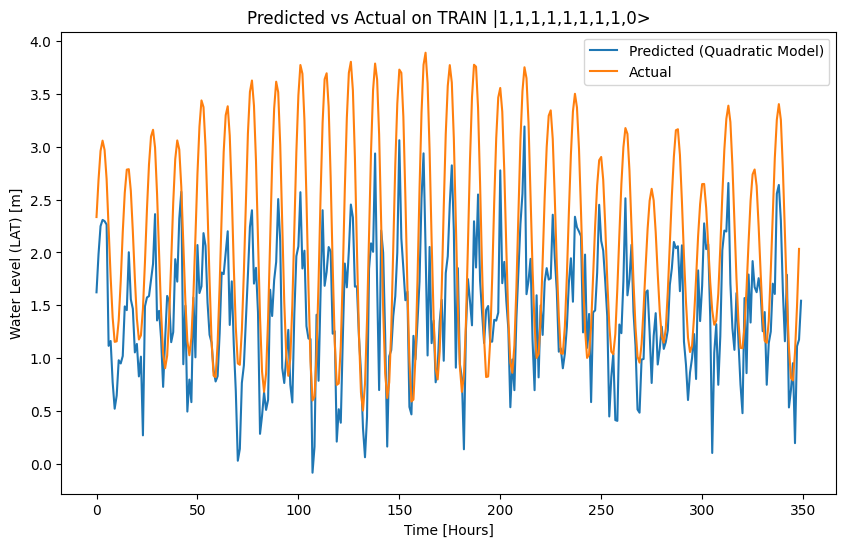

In [95]:
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'reg_quad' is your trained quadratic model and 'train_expectation_matrix' is available

# Transform the training data to include quadratic terms
train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)

# Make predictions using the quadratic model
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predicted_train_data_quad[:], label='Predicted (Quadratic Model)')
plt.plot(new_data[1:-split_int], label='Actual')
plt.title(f'Predicted vs Actual on TRAIN {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.show()


# Plot full data

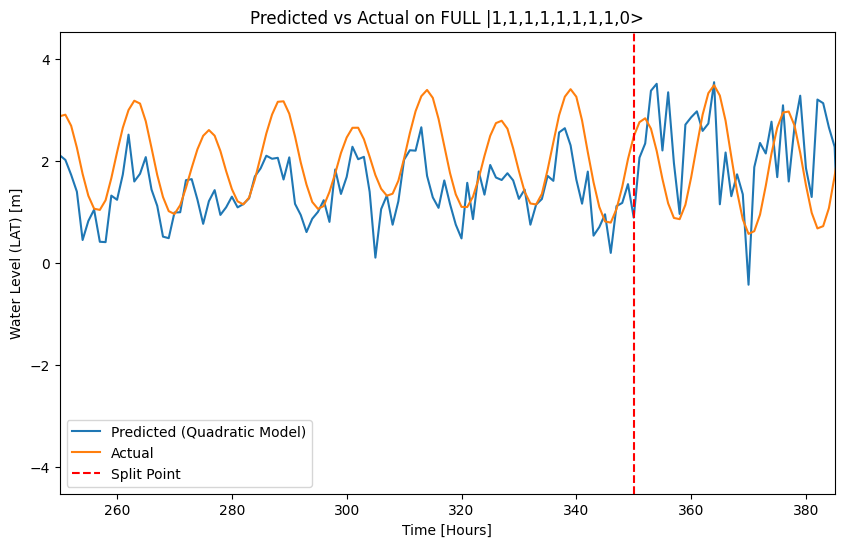

In [96]:
# append predicted train quad and test quad
FULL_data_quad = np.append(predicted_train_data_quad, predicted_test_data_quad)[:]



# Plotting
plt.figure(figsize=(10, 6))
plt.plot(FULL_data_quad, label='Predicted (Quadratic Model)')
plt.plot(new_data[:], label='Actual')
plt.axvline(x=len(FULL_data_quad)-split_int, color='r', linestyle='--', label='Split Point')
plt.title(f'Predicted vs Actual on FULL {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')

# Set the x-axis limits to zoom in
x_min = 250  # Replace with your desired minimum x-value
x_max = 385 # Replace with your desired maximum x-value
plt.xlim(x_min, x_max)

plt.legend()
plt.show()


# SMOOTHED FUNCTION

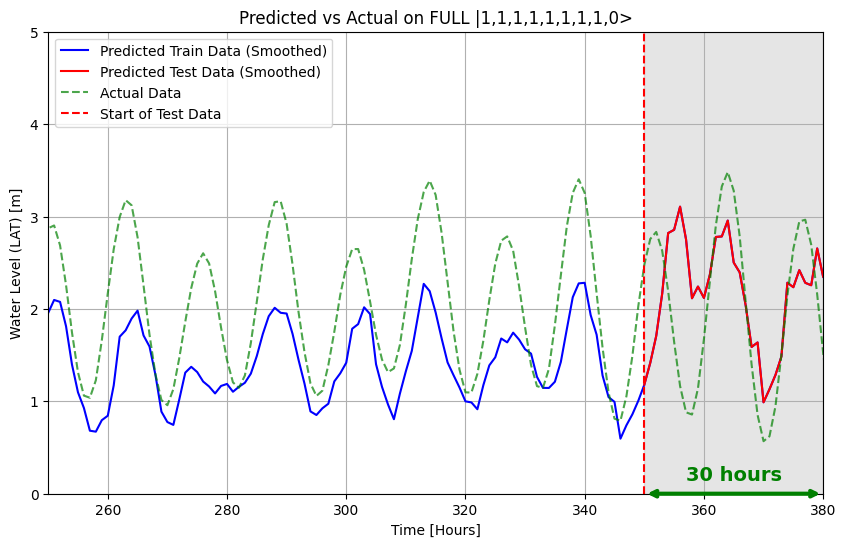

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'predicted_train_data_quad', 'predicted_test_data_quad', and 'new_data' are defined

# Append predicted train quad and test quad
FULL_data_quad = np.append(predicted_train_data_quad, predicted_test_data_quad)

# Convert the FULL_data_quad array to a pandas Series for easy manipulation
FULL_data_quad_series = pd.Series(FULL_data_quad)

# Apply a moving average (rolling mean)
window_size = 4  # Adjust the window size as needed
FULL_data_quad_smoothed = FULL_data_quad_series.rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the smoothed train predictions in blue and connect to test predictions
plt.plot(FULL_data_quad_smoothed, color='blue', label='Predicted Train Data (Smoothed)')

# Plot the smoothed test predictions in red from test_start_index
test_start_index = len(predicted_train_data_quad)
plt.plot(range(test_start_index, len(FULL_data_quad_smoothed)), FULL_data_quad_smoothed[test_start_index:], color='red', label='Predicted Test Data (Smoothed)')


# Plot the actual data in green dashed line
plt.plot(new_data[:], color='green', alpha=0.7, linestyle='--', label='Actual Data')

# Add a vertical line at test_start_index
plt.axvline(x=test_start_index, color='red', linestyle='--', label='Start of Test Data')


# Shade the test data region
x_max = 380  # Replace with your desired maximum x-value
plt.fill_betweenx(y=[-10, 10], x1=test_start_index, x2=x_max, color='grey', alpha=0.2)

# Set title and labels
plt.title(f'Predicted vs Actual on FULL {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')

# Set the x-axis limits to zoom in
x_min = 250  # Replace with your desired minimum x-value
plt.xlim(x_min, x_max)

y_min = 0
y_max = 5
plt.ylim(y_min, y_max)

# Add a horizontal double arrow
hours_length = x_max - test_start_index
plt.annotate(
    '', 
    xy=(test_start_index, 0), xycoords='data',
    xytext=(test_start_index + hours_length, 0), textcoords='data',
    arrowprops=dict(arrowstyle='<->', color='green', linewidth=3)
)

# Increase the y-coordinate for text to add space between the text and the arrow
text_y_position = 0.1
plt.text(test_start_index + hours_length / 2, text_y_position, f'{hours_length} hours', 
         verticalalignment='bottom', horizontalalignment='center', 
         color='green', fontsize=14, fontweight='bold')

plt.legend()
plt.grid(True)
plt.show()
